In [18]:
# Imports
import numpy as np
import keras
from keras.datasets import imdb
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, regularizers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow as tf
import random

np.random.seed(42)
# Print the number of GPUs
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))


class soc_nn:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def run(self):
        # Building the model
        model = Sequential()
        model.add(Dense(18, input_dim=len(self.x_train[0])))
        # (Dense(50, activation='relu', input_shape=self.x_train[0].shape))
        # model.add(BatchNormalization())
        model.add(Dense(12, activation='relu'))
        # model.add(Dense(120, activation='relu'))
        # model.add(Dense(20, activation='relu'))
        # model.add(Dropout(.1))
        # model.add(BatchNormalization())
        model.add(Dense(1, activation='sigmoid'))

        # Optimizer
        adam = optimizers.Adam(lr=0.0001)
        adadelta = optimizers.Adadelta(lr=1.0, rho=0.95)
        rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9)

        # Compiling the model
        model.compile(loss='mean_absolute_error', optimizer=adadelta, metrics=['binary_accuracy', 'categorical_accuracy'])

        # [['accuracy'], ['accuracy', 'mse']]
        model.summary()

        # Training the model
        model.fit(self.x_train, self.y_train, epochs=300, validation_data=(self.x_test, self.y_test),
                  batch_size=500, verbose=1)

        # Evaluating the model on the training and testing set
        score = model.evaluate(self.x_train, self.y_train)
        print("\n Training Accuracy:", score[1])
        score = model.evaluate(self.x_test, self.y_test)
        print("\n Testing Accuracy:", score[1])

        # Running and evaluating the model
        # hist = model.fit(self.x_train, self.y_train,
        #                  batch_size=3,
        #                  epochs=10,
        #                  validation_data=(self.x_test, self.y_test),
        #                  verbose=2)

        score = model.evaluate(self.x_test, self.y_test, verbose=0)
        print("Accuracy: ", score[1])
            
        return model

def scale_between_0_and_1(df, label):
   return (df[label] + abs(min(df[label]))) / (max(df[label]) + abs(min(df[label])))

def data_prep(data):
    # Prepare usable input parameters
    y = scale_between_0_and_1(data, 'SoC')
    x = data.drop(['sample_id', 'date', 'actual_time', 'mode', 'B_E', 'I_m',
                       'T_1', 'T_2', 'T_3', 'delta_time', 'runtime', 'SoC'], axis=1)
    
    # x['T'] = round((data['T_1'] + data['T_2'] + data['T_3']) / 3, 1)
    
    # Normalize data
    x['I_m'] = round(data['mode'] * data['B_E'] * data['I_m'], 3)
    x['I'] = scale_between_0_and_1(x, 'I_m')
    x['C'] = scale_between_0_and_1(data, 'C')
    x['U_b'] = scale_between_0_and_1(data, 'U_b')
    x['dV'] = scale_between_0_and_1(data, 'dV')
    x['dV2'] = scale_between_0_and_1(data, 'dV2')
    x['dV3'] = scale_between_0_and_1(data, 'dV3')
    
    # Divide measurements based on charging load profile
    x_load = pd.DataFrame()
    x_load['ch1'] = x['U_b']
    x_load['ch2'] = x['dV']
    x_load['ch3'] = x['dV2']
    x_load['ch4'] = x['dV3']
    x_load['ch5'] = x['C']
    x_load['ch6'] = round(data['mode'] * data['B_E'] * data['I_m'], 3)
    x_load['idle1'] = x['U_b']
    x_load['idle2'] = x['dV']
    x_load['idle3'] = x['dV2']
    x_load['idle4'] = x['dV3']
    x_load['idle5'] = x['C']
    x_load['idle6'] = round(data['mode'] * data['B_E'] * data['I_m'], 3)
    x_load['dsch1'] = x['U_b']
    x_load['dsch2'] = x['dV']
    x_load['dsch3'] = x['dV2']
    x_load['dsch4'] = x['dV3']
    x_load['dsch5'] = x['C']
    x_load['dsch6'] = round(data['mode'] * data['B_E'] * data['I_m'], 3)
    
    # Clear-up 
    # 1st third of the inputs to represent charging 'ch'
    # 2nd third of the inputs to represent Standby or Bypass 'idle'
    # 3rd third of the inputs to represent discharging 'dsch'
    x_load['ch1'].values[x['I_m'] <= 0] = 0
    x_load['ch2'].values[x['I_m'] <= 0] = 0
    x_load['ch3'].values[x['I_m'] <= 0] = 0
    x_load['ch4'].values[x['I_m'] <= 0] = 0
    x_load['ch5'].values[x['I_m'] <= 0] = 0
    x_load['ch6'].values[x['I_m'] <= 0] = 0
    x_load['idle1'].values[x['I_m'] != 0] = 0
    x_load['idle2'].values[x['I_m'] != 0] = 0
    x_load['idle3'].values[x['I_m'] != 0] = 0
    x_load['idle4'].values[x['I_m'] != 0] = 0
    x_load['idle5'].values[x['I_m'] != 0] = 0
    x_load['idle6'].values[x['I_m'] != 0] = 0
    x_load['dsch1'].values[x['I_m'] >= 0] = 0
    x_load['dsch2'].values[x['I_m'] >= 0] = 0
    x_load['dsch3'].values[x['I_m'] >= 0] = 0
    x_load['dsch4'].values[x['I_m'] >= 0] = 0
    x_load['dsch5'].values[x['I_m'] >= 0] = 0
    x_load['dsch6'].values[x['I_m'] >= 0] = 0
    
    # Normalize ch6 - I_m and dsch6 - I_m
    x_load['ch6'] = x_load['ch6'] / (max(x_load['ch6']))
    x_load['dsch6'] = x_load['dsch6'] / abs(min(x_load['dsch6']))
    
    return x_load, y
    

# Load the dataset
data_1 = pd.read_csv('data/Augmented_data/battery_data_1_dV-C-roundV.csv')
print("battery_data_1 has {} data points with {} variables each."
      .format(*data_1.shape))
data_2 = pd.read_csv('data/Augmented_data/battery_data_2_dV-C-roundV.csv')
print("battery_data_2 has {} data points with {} variables each."
      .format(*data_2.shape))

x_1, y_1 = data_prep(data_2)
x_2, y_2 = data_prep(data_1)

# print(x_1, y_1)

# Create training and testing dataset
x_test, y_test = x_1.to_numpy(), y_1.to_numpy()
x_train, y_train = x_2.to_numpy(), y_2.to_numpy()

# train_size = int(len(x_1)/2)
# test_size = len(x_1) - train_size
# x_train = x_1[:train_size]
# y_train = y_1[:train_size]
# x_test = x_1[train_size:]
# y_test = y_1[train_size:]

print("x_train has {} data points with {} variables each.".format(*x_train.shape))
print("x_test has {} data points with {} variables each.".format(*x_test.shape))

soc_nn = soc_nn(x_train, y_train, x_test, y_test)
model = soc_nn.run()

Num GPUs Available:  1
battery_data_1 has 146565 data points with 17 variables each.
battery_data_2 has 106710 data points with 17 variables each.
x_train has 146565 data points with 18 variables each.
x_test has 106710 data points with 18 variables each.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________
Train on 146565 samples, validate on 106710 samples
Epoch 1/300
146565/146565 [==============================] - 1s 10us/step - loss: 0.0870 - binary_ac

In [19]:
pred = model.predict(x_test, batch_size=32, verbose=0)
import csv
with open('asd.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(pred)


In [20]:
# print(pred)

prediction_pd = pd.DataFrame({'SoC': pred[:, 0]})

print(y_1,prediction_pd,data_1)

0         0.022353
1         0.022353
2         0.022417
3         0.022471
4         0.022535
            ...   
106705    0.022268
106706    0.022268
106707    0.022268
106708    0.022268
106709    0.022268
Name: SoC, Length: 106710, dtype: float64              SoC
0       0.036748
1       0.068237
2       0.054534
3       0.061700
4       0.061734
...          ...
106705  0.047537
106706  0.047537
106707  0.047537
106708  0.047537
106709  0.047537

[106710 rows x 1 columns]         sample_id               date  actual_time  mode  B_E    I_m   U_b  \
0               1  13-03-19 11:57:25            0     0    0   0.00  2.51   
1               2  13-03-19 13:03:28         3963     1    1  33.33  2.75   
2               3  13-03-19 13:03:29         3964     1    1  33.33  2.76   
3               4  13-03-19 13:03:29         3964     1    1  33.33  2.77   
4               5  13-03-19 13:03:30         3965     1    1  33.33  2.78   
...           ...                ...          ...   ... 

C:\Users\gergo\Anaconda3\envs\quadcop\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\gergo\Anaconda3\envs\quadcop\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


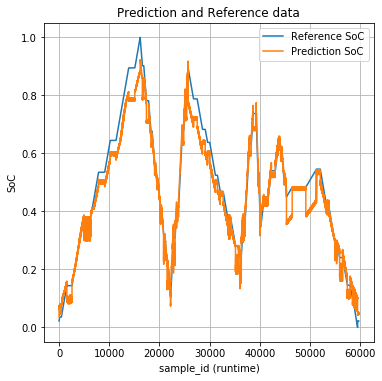

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_run(data, reference, prediction):
    data['SoC'] = scale_between_0_and_1(data, 'SoC')
    plt.subplots(figsize=(15, 15))
    
    # 
    plt.subplot(3, 3, 1)
    plt.title('Prediction and Reference data')
    plt.plot(data['runtime'], data['SoC'], label='Reference SoC')
    plt.plot(data['runtime'], prediction['SoC'], label='Prediction SoC')
    # plt.plot(data['runtime'], data['I_m'], label='I_m')
    plt.xlabel('sample_id (runtime)')
    plt.ylabel('SoC')
    plt.grid(True)
    plt.legend()

    # # Speed of Drone
    # plt.subplot(3, 3, 2)
    # plt.title('Velocity')
    # plt.plot(results['time'], results['x_velocity'], label='x_hat')
    # plt.plot(results['time'], results['y_velocity'], label='y_hat')
    # plt.plot(results['time'], results['z_velocity'], label='z_hat')
    # plt.xlabel('time, seconds')
    # plt.ylabel('Velocity')
    # plt.grid(True)
    # plt.legend()
    # 
    # # Euler angles
    # plt.subplot(3, 3, 3)
    # plt.title('Orientation')
    # plt.plot(results['time'], results['phi'], label='phi')
    # plt.plot(results['time'], results['theta'], label='theta')
    # plt.plot(results['time'], results['psi'], label='psi')
    # plt.xlabel('time, seconds')
    # plt.grid(True)
    # plt.legend()
    # 
    # # Plot the velocity (rad/sec) of each Euler angle
    # plt.subplot(3, 3, 4)
    # plt.title('Angular Velocity')
    # plt.plot(results['time'], results['phi_velocity'], label='phi')
    # plt.plot(results['time'], results['theta_velocity'], label='theta')
    # plt.plot(results['time'], results['psi_velocity'], label='psi')
    # plt.xlabel('time, seconds')
    # plt.grid(True)
    # plt.legend()
    # 
    # # Plot rotor speed
    # plt.subplot(3, 3, 5)
    # plt.title('Rotor Speed')
    # plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1')
    # plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2')
    # plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3')
    # plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4')
    # plt.xlabel('time, seconds')
    # plt.ylabel('Rotor Speed, revolutions / second')
    # plt.grid(True)
    # plt.legend()

    plt.tight_layout()
    plt.show()


plot_run(data_2, y_1, prediction_pd)



In [23]:
error = abs(y_1 - prediction_pd['SoC'])
print(error.mean())
print(1-error.mean())


0.04054301096125913
0.9594569890387409
